In [1]:
import numpy as np
from numpy.linalg import norm 
import scipy.sparse
from scipy.sparse import identity
from scipy import linalg
from scipy.sparse import csr_matrix
import math
import matplotlib.pyplot as plt

In [2]:
def sos(A,b,x):
    s = np.dot(A, x) - b
    so = np.dot(s.T,s)
    sos = int(so)
    return sos

In [3]:
def objective(A, b , lamda,x,z):
    p = (1/2)*sos(A,b,x) + lamda*norm(z,1)
    return p

In [4]:
def shrinkage(x,kappa):
    z = np.zeros(x.shape)
    for i in range(x.size):
        z[i] = max(0, x[i][0]-kappa) - max(0, -x[i][0]-kappa)
    return z

In [5]:
def factor(A,rho):
    (m,n) = A.shape
    if(m>=n):
        t = np.dot(A.T,A) + rho*identity(n)
        L = linalg.cholesky(t,lower=True)
    else:
        t = identity(m) + (1/rho*np.dot(A,A.T))
        L = linalg.cholesky(t,lower=True)
    U  = L.T
    return L,U

In [6]:
class historyfunc:
  def __init__(self,objval,r_norm,s_norm,eps_pri,eps_dual):
    self.objval = objval
    self.r_norm = r_norm
    self.s_norm = s_norm
    self.eps_pri = eps_pri
    self.eps_dual = eps_dual

In [7]:
def lasso(A, b , lamda,rho,alpha):
    QUIET    = False
    MAX_ITER = 1000
    ABSTOL   = 1e-4
    RELTOL   = 1e-2
    (m,n) = A.shape
    Atb = np.dot(A.T,b);
    x = np.zeros([n, 1], dtype=float)
    z = np.zeros([n, 1], dtype=float)
    u = np.zeros([n, 1], dtype=float)
    [L, U] = factor(A, rho)
    objval = np.zeros([MAX_ITER, 1], dtype=float)
    r_norm = np.zeros([MAX_ITER, 1], dtype=float)
    s_norm = np.zeros([MAX_ITER, 1], dtype=float)
    eps_pri = np.zeros([MAX_ITER, 1], dtype=float)
    eps_dual = np.zeros([MAX_ITER, 1], dtype=float)
    if not QUIET:
        print('iter\tr_norm\t\teps_pri\t\ts_norm\t\teps_dual\tobjective')
    for k in range(MAX_ITER):
        
        #updating x 
        
        q = Atb + rho*(z - u)
        if(m>n):
         
            x = np.dot(np.linalg.inv(U),np.dot(np.linalg.inv(L),q))
        else:
      
            x=(q/rho)-(np.dot(A.T,np.dot(np.linalg.inv(U),np.dot(np.linalg.inv(L),np.dot(A,q))))/rho**2)

        # z update
        zold = z
        x_hat = alpha*x + (1-alpha)*zold
   
        z = shrinkage((x_hat + u),lamda/rho)
   
        # u update
        u = u + (x_hat - z)
      
        # diagnostics
     
        history = historyfunc(objval,r_norm,s_norm,eps_pri,eps_dual)
        
        history.objval[k] = objective(A,b,lamda,x,z)
        
        history.r_norm[k] = norm(x-z)
        history.s_norm[k] = norm(-rho*(z - zold))
        
        history.eps_pri[k] = math.sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z))
        history.eps_dual[k]= math.sqrt(n)*ABSTOL + RELTOL*(norm(rho*u))
        if not QUIET:
            print(k,'\t',history.r_norm[k],'\t',history.eps_pri[k],'\t',history.s_norm[k],'\t',history.eps_dual[k],'\t',history.objval[k])
            
        if history.r_norm[k] < history.eps_pri[k] and history.s_norm[k] < history.eps_dual[k]:
            break
    return x,history

In [8]:
def temp(A,n):
    A = np.square(A)
    s = np.sum(A,axis=0)
    ss = np.sqrt(s)
    sss=np.divide(1,ss)
    spd = ((scipy.sparse.spdiags(sss.T,0,n,n)).toarray())
    A = np.dot(A,spd)
    return A

In [9]:
def temp2(A,x,m):
    ax = np.dot(A,x)
    r = np.random.randn(m,1)
    s = math.sqrt(0.001)
    m = s*r
    b = np.add(ax,m)
    return b

In [10]:
#m = 1500
#n = 5000
#p = 100/n
#x = (scipy.sparse.random(n, 1, density=p)).toarray()
#A = np.random.randn(m,n)
#A = temp(A,n)

#b = temp2(A,x,m)

#Atb=np.dot((A.T),b)

#lambda_max=norm(Atb)
#lamda=0.1*lambda_max
#[x,history] = lasso(A, b, lamda, 1.0, 1.0)

In [11]:
import pandas as pd

A=pd.read_csv('input_param_A.csv', header=None ).to_numpy()
b=pd.read_csv('input_param_b.csv', header=None ).to_numpy()

lambda_max=pd.read_csv('input_param_lambdaMax.csv', header=None ).to_numpy()
lamda=0.1*lambda_max

[x,history] = lasso(A, b, lamda, 1.0, 1.0)

iter	r_norm		eps_pri		s_norm		eps_dual	objective
0 	 [3.7047662] 	 [0.04652633] 	 [0.72499527] 	 [0.04411873] 	 [3.15813365]
1 	 [2.26535912] 	 [0.04088321] 	 [1.79598694] 	 [0.0653367] 	 [9.79452236]
2 	 [1.09575632] 	 [0.05287333] 	 [2.03250578] 	 [0.07339211] 	 [14.80334227]
3 	 [0.80503393] 	 [0.06867643] 	 [1.72189392] 	 [0.07358742] 	 [17.50171248]
4 	 [0.8619378] 	 [0.08007989] 	 [1.22337588] 	 [0.07044622] 	 [18.3307153]
5 	 [0.80777708] 	 [0.08643004] 	 [0.76693778] 	 [0.06667701] 	 [18.73984045]
6 	 [0.66112671] 	 [0.08893696] 	 [0.43981524] 	 [0.06345694] 	 [18.44098349]
7 	 [0.49056183] 	 [0.08898872] 	 [0.2659187] 	 [0.06115591] 	 [18.15470398]
8 	 [0.33790867] 	 [0.08775237] 	 [0.21588676] 	 [0.0597618] 	 [18.07338932]
9 	 [0.22554643] 	 [0.0860882] 	 [0.19869221] 	 [0.05910346] 	 [17.35748175]
10 	 [0.15845804] 	 [0.084523] 	 [0.17213206] 	 [0.05896614] 	 [17.11954596]
11 	 [0.12115585] 	 [0.08330575] 	 [0.13794787] 	 [0.05914737] 	 [16.91923676]
12 	 [0.09785848] 	 [0.0

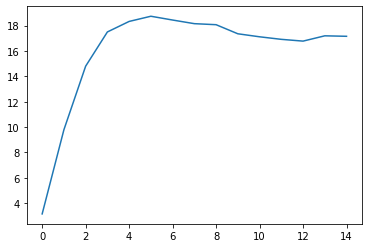

In [12]:
objval = history.objval
objval = objval[objval!=0]
plt.plot(np.array(range(objval.size)), objval)
plt.show()

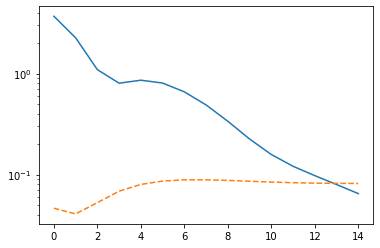

In [13]:
r_norm = history.r_norm
r_norm = r_norm[r_norm!=0]
eps_pri = history.eps_pri
eps_pri = eps_pri[eps_pri!=0]
plt.semilogy(np.array(range(r_norm.size)),r_norm)
plt.semilogy(np.array(range(eps_pri.size)),eps_pri,linestyle='dashed')
plt.show()

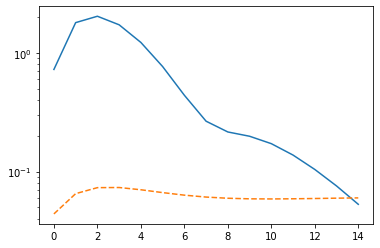

In [14]:
s_norm = history.s_norm
s_norm = s_norm[s_norm!=0]
eps_dual = history.eps_dual
eps_dual = eps_dual[eps_dual!=0]
plt.semilogy(np.array(range(s_norm.size)),s_norm)
plt.semilogy(np.array(range(eps_dual.size)),eps_dual,linestyle='dashed')
plt.show()

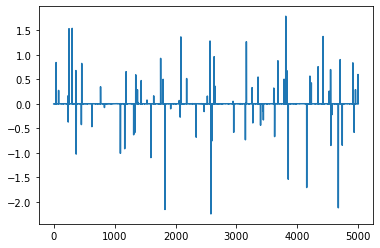

In [15]:
plt.plot(x)
plt.show()